FFR 120  
Felix Waldschock

HW 2  
Exercise 7.6

In [1226]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','grid'])
from tqdm import trange


In [1245]:
# Simulation parameters
L = 100                                     # length of the box
sigma = 1
dT = .01

N = 1000                                    # number of trajectiories (particles)
T_tot = [1000]                              # total time
T_tot = np.array(T_tot)
Iteration_Steps = T_tot * (1 / dT)          # total number of steps 
max_steps = int(np.max(Iteration_Steps))    # maximum number of steps

# parameters
n_drift = 15
n_diff = 1

x0 = 0                                      # initial position of the particle
alpha = 1
sigma0 = 1
dSigma = 1.8 

numberOfIntervalls = 100
Lk = L / numberOfIntervalls
IntervallCenters = np.linspace(0, (numberOfIntervalls-1)*Lk, numberOfIntervalls) + Lk/2 - L/2


0.5


In [1228]:
# constant noise simulation ex 7.2, create a trajectory matrix containing trajectories of all particles

def simulate_trajectory_constant(N, max_steps, L):
    # x = np.zeros(N)*x0
    x = np.random.uniform(-L/2, L/2, N)
    
    trajectories = np.zeros((N, len(T_tot)))                             # array to store trajectories  
    sigmas_ = np.zeros(N)                                                # array to store sigmas
        
    trajectoryTensor = np.zeros((N, max_steps))

    for s in trange(max_steps):
        # calc new sigma
        o = sigma * np.sqrt(dT)
        directions = np.random.choice([-1, 1], N)
        x += directions * o
        
        # check boundaries and apply correction
        x = np.where(x < -L/2, -L - x, x)
        x = np.where(x > L/2, L - x, x)
        
        trajectoryTensor[:,s] = x
    
    trajectories[:, -1] = x
    sigmas_[:] = sigma

    
    return trajectories, sigmas_, trajectoryTensor

In [1229]:
# multiplicative noise 
def simulate_trajectory_multiplicative(N, max_steps, L, alpha):
    #x = np.ones(N)*x0
    x = np.random.uniform(-L/2, L/2, N)

    trajectories = np.zeros((N, len(T_tot)))                            # array to store trajectories  
    sigmas_ = np.zeros(N)                                               # array to store sigmas
 
    trajectoryTensor = np.zeros((N, max_steps))

    for s in trange(max_steps):
        
        # get new noise
        sigma = np.zeros(N)
        # multiplicative noise
        tmp1 = sigma0 + dSigma*x/L
        tmp2 = dSigma * dT / L
        tmp3 = tmp1 * np.sqrt(dT)
        direction = np.random.choice([-1,1], N)
        sigma = alpha * tmp1 * tmp2 + tmp3 * direction
        
        x += sigma

        # check boundaries and apply correction
        x = np.where(x < -L/2, -L - x, x)
        x = np.where(x > L/2, L - x, x)

        trajectoryTensor[:,s] = x
    
        if s in Iteration_Steps:
            index = np.where(Iteration_Steps == s)[0][0]
            trajectories[:, index] = x

    trajectories[:, -1] = x
    sigmas_ = sigma

    return trajectories, sigmas_, trajectoryTensor


In [1230]:
# Run constant simulation
trajectories_constant, sigmas_constant, trajectoryTensor_constant = simulate_trajectory_constant(N, max_steps, L)


100%|██████████| 100000/100000 [00:01<00:00, 50207.56it/s]


In [1231]:
# Run multiplicative simulation
trajectories_multiplicative, sigmas_multiplicative, trajectoryTensor_multiplicative = simulate_trajectory_multiplicative(N, max_steps, L, alpha)
print(trajectoryTensor_multiplicative.shape)

100%|██████████| 100000/100000 [00:03<00:00, 32651.77it/s]

(1000, 100000)


In [1232]:
def computeDriftDiff(trajectoryTensor, name):
    # if a particle is in an intervall, check where it is after n_drift steps, use this difference to getDrift
    drift = np.zeros(numberOfIntervalls)
    driftCounter = np.ones(numberOfIntervalls)
    diff = np.zeros(numberOfIntervalls)
    diffCounter = np.ones(numberOfIntervalls)

    # trajecoryTensor comes in dimension (N, max_steps)
    numP = trajectoryTensor.shape[0]
    numSteps = trajectoryTensor.shape[1]

    # loop over all particles
    for p in trange(numP):
        # loop over all time steps
            for s in range(numSteps-n_drift-1):
                currentParticle = trajectoryTensor[p, s]
                # check from which intervallCenter the particle lays < Lk/2 away
                intervallIndex = np.where(np.abs(currentParticle - IntervallCenters) <= Lk/2)[0][0]

                # check where the particle is after n_drift steps and add to drift array, increment counter
                driftDifference = trajectoryTensor[p,s+n_drift] - currentParticle
                diffDifference = trajectoryTensor[p,s+n_diff] - currentParticle

                drift[intervallIndex] += driftDifference
                if(driftDifference != 0):
                    driftCounter[intervallIndex] += 1
                diff[intervallIndex] += diffDifference**2
                if(diffDifference != 0):
                    diffCounter[intervallIndex] += 1


    # save diff and diffCounter
    np.save("diff_"+name+".npy", diff)
    np.save("diffCounter_"+name+".npy", diffCounter)

    # implement the formulas 7.13 / 7.14

    # 7.13
    drift = drift/driftCounter
    drift = drift/(dT * n_drift)

    # take average
    diff = diff/diffCounter

    diff = diff/(dT * n_diff *2)

    #print(driftCounter)

    if np.isnan(drift).all():
        print("drift nan")

    # print(drift)

    # if nan set to zero  
    drift[np.isnan(drift)] = 0
    diff[np.isnan(diff)] = 0

    return drift, driftCounter, diff, diffCounter

In [1234]:
# compute the drift and diffusion for both simulation trajectories
if(1):
    drift_constant, driftCounter_const, diffusion_constant, diffCounter_const = computeDriftDiff(trajectoryTensor_constant,"const")



100%|██████████| 1000/1000 [04:19<00:00,  3.85it/s]


In [1235]:
if(1):
    drift_multiplicative, driftCounter_mult, diffusion_multiplicative, diffCounter_mult = computeDriftDiff(trajectoryTensor_multiplicative,"mult")


100%|██████████| 1000/1000 [04:18<00:00,  3.87it/s]


In [1250]:
def getPosDerivate(array):
    # get the derivative of the array in regard of the position
    # returns the derivative array
    derivative = np.zeros(len(array))
    for i in range(1, len(array)):
        derivative[i] = (array[i] - array[i-1]) / Lk
    return derivative
    

In [1251]:
# calculate the noise induced drift -> derivative of the diffusion
noiseInducedConstant = getPosDerivate(diffusion_constant)
noiseInducedMultiplicative = getPosDerivate(diffusion_multiplicative)

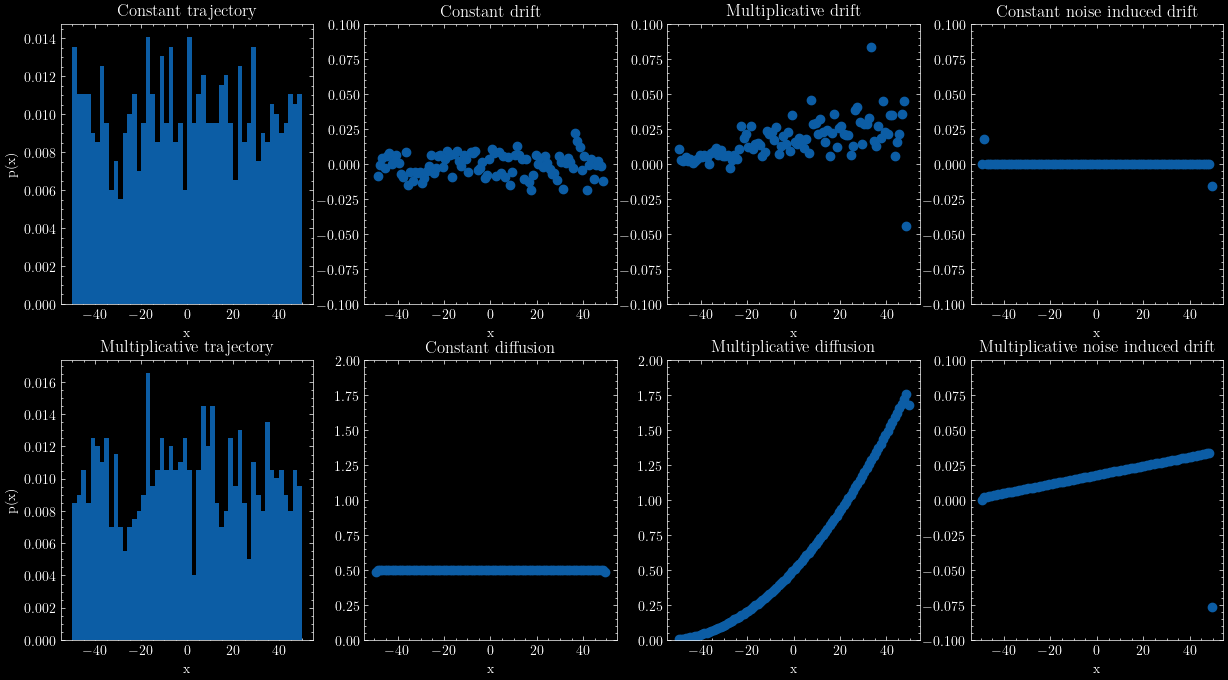

In [1252]:
# plot a 2x3 subplot
fig, axs = plt.subplots(2, 4, figsize=(15,8))
x_init = np.linspace(-L/2, L/2, N)

# plot the constantDrift and conStantDiffusion in 1 and 2
axs[0, 0].hist(trajectories_constant, bins=50, density=True, label='constant drift')
axs[0, 0].set_title('Constant trajectory')
axs[0, 0].set(ylabel='p(x)')

axs[1, 0].hist(trajectories_multiplicative, bins=50, density=True, label='multiplicative trajectory')
axs[1, 0].set_title('Multiplicative trajectory')
axs[1, 0].set(ylabel='p(x)')

axs[0, 1].plot(IntervallCenters,drift_constant, 'o',label='constant noise')
axs[0, 1].set_title('Constant drift')
axs[0, 1].set_ylim(-0.1, 0.1)

axs[1, 1].plot(IntervallCenters,diffusion_constant,'o', label='constant noise')
axs[1, 1].set_title('Constant diffusion')
axs[1, 1].set_ylim(-0, 2)

axs[0, 2].plot(IntervallCenters,drift_multiplicative, 'o', label='multiplicative noise')
axs[0, 2].set_title('Multiplicative drift')
axs[0, 2].set_ylim(-0.1, 0.1)

axs[1, 2].plot(IntervallCenters,diffusion_multiplicative,'o', label='multiplicative noise')
axs[1, 2].set_title('Multiplicative diffusion')
axs[1, 2].set_ylim(-0, 2)

axs[0, 3].plot(IntervallCenters,noiseInducedConstant, 'o',label='constant noise')
axs[0, 3].set_title('Constant noise induced drift')
axs[0, 3].set_ylim(-0.1, 0.1)

axs[1, 3].plot(IntervallCenters,noiseInducedMultiplicative, 'o',label='multiplicative noise')
axs[1, 3].set_title('Multiplicative noise induced drift')
axs[1, 3].set_ylim(-0.1, 0.1)


# set x label for all plots "x"
for ax in axs.flat:
    ax.set(xlabel='x')

# d)
Yes there is a trendline with slope > 0, indicating that particles evaulated with multiplicative noise are tend to drift more as x increases.